# <center> A Complete Guide to Logistic Regression </center>

### <center> Support me with an upvote if you find it useful! 👍 </center>

## Table of Contents

<a id="toc"></a>

- [1. Introduction](#1)
    - 1.1 What is Logistic Regression?
    - 1.2 Why it is called regression?
        
        
- [2. How to find the best-fit Sigmoid Curve?](#2)
    - 2.1 Maximum Likelihood Estimation
    - 2.2 The Likelihood and Loss Functions
   

- [3. Example: Bankruptcy Prediction ](#3)
    - 3.1 Parameters Tuning

<a id="1"></a>

# <center>Introduction</center>

## What is Logistic Regression?

**`Logistic Regression`** is a **classification method** that estimates the **proability** of an event occuring.

Even though it has the word **Regression** in its name, it is not a regression mehtod that returns continuous values as outputs. Instead, it returns the **probability of getting Y=1** for a **binary output variable**  (either 0 or 1).

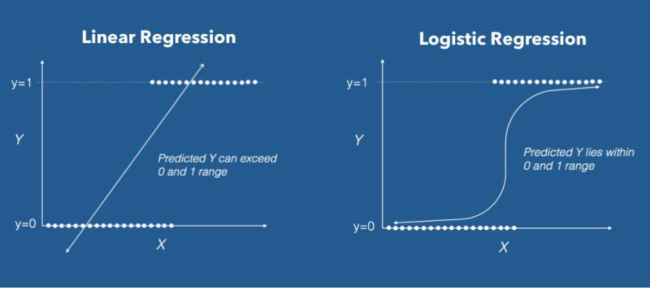

Image Source: https://www.datacamp.com/tutorial/logistic-regression-R

As demonstarted in the diagram above, logistic regression fits a **S-curve** to model the relationship between the input variables X and the binary output variable Y. This curve is known as the **`Sigmoid Curve`**. The **y-values** on the sigmoid curve represents the probability of having Y=1 at the selected X values. 

By setting a **probability threshold** (e.g. for P > 0.5, we classify the output as Y=1), we can use the outputs from a logistic regression to make **binary classification predictions**.

## Why is it called regression?

This model is called regression because the **`log-odds`** of its output probability follows a **linear relationship** with the input variables X:

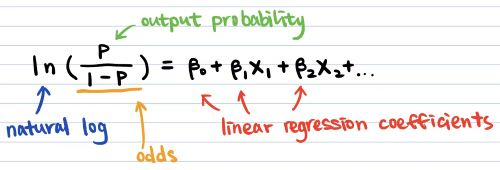

Why don't we just use linear regression?

As shown above, linear regression outputs the **log-odds** which has the range from **-∞ to ∞**. However, the probability of a binary output can only be within the range of **0 to 1**. Therefore, logistic regression applies a **`sigmoid function`** to the log-odds and turns it into a reasonable probability value:

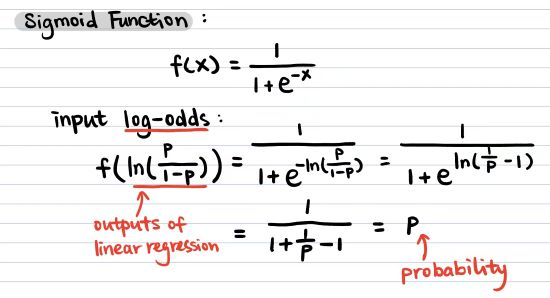

<a id="2"></a>

# <center>How to find the best-fit Sigmoid Curve?</center>

## Maximum Likelihood Estimation

In linear regression, the parameters of the best-fit like are estimated using **Least Square Estimation** which minimizes the **sum of squared errors** between the predictions and the actual Y values. (Learn more about linear regression here: [A Complete Guide to Linear Regression](https://www.kaggle.com/code/ryanluoli2/a-complete-guide-to-linear-regression))

However, in the case of **binary output calssification** the calculation of sqaured error is not meaningful as the output is **categorical** but not continuous. Therefore, Logistic Regression uses **`Maximum Likelihood Estimation (MLE)`** to find the best parameters which aims to maximize the **likelihood** of obtaining the observed outcomes given the parameters of a sigmoid curve.

## The Likelihood and Loss Function   

The **`likelihood function`** is the **joint probability** of obtaining the observed outcomes:

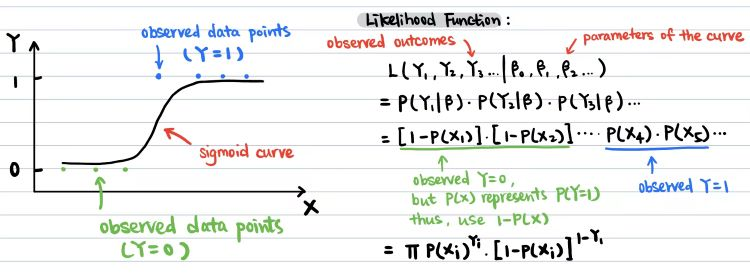

To find the **optimal parameters** for the sigmoid curve, we need to **maximize the likelihood function** demonstarted above.

To make the optimization process easier, we usually **minimize a loss function** derived from the likelihood function instead of directly maximize the likelihood：

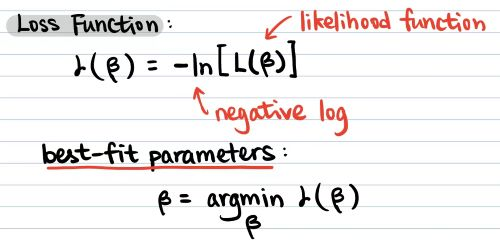

<a id="3"></a>

# <center>Example: Bankruptcy Prediction</center>

The following data comes from the competition: https://www.kaggle.com/competitions/bankruptcy-risk-prediction

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_validate, KFold, cross_val_score

### Import Data

In [2]:
df_train = pd.read_csv('../input/bankruptcy-risk-prediction/train.csv')
df_test = pd.read_csv('../input/bankruptcy-risk-prediction/test.csv')

### Data Preparation

In [3]:
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

cat_features = df.columns[df.dtypes == 'object'].to_list()
cat_features.append('bankruptcy')
num_features = df.columns[df.dtypes != 'object'].to_list()
num_features.remove('bankruptcy')
num_features.remove('id')

#drop the id column
df1 = df.drop(['id'], axis=1).copy()

#encode all the categorical variables with aggregated percentage of bankruptcy
df2 = df1.copy()
for feature in cat_features[:-1]:
    df2[feature] = df2.groupby([feature])['bankruptcy'].transform(np.mean)
    
#standardize all the numerical features
df3 = df2.copy()
scaler = StandardScaler()
df3[df3.columns[:-1]] = scaler.fit_transform(df3[df3.columns[:-1]])

#split the data back to train and test sets
X_train = df3.iloc[:df_train.shape[0],:-1].copy()
y_train = df3.iloc[:df_train.shape[0],-1].copy()
X_test = df3.iloc[df_train.shape[0]:,:-1].copy()

### Evaluation Metric

Here we use the **area under the ROC curve** as our evaluation metric.

In [4]:
def kf_cross_val(model, X, y): 
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        x_train = X.iloc[train_index]
        y_train = y.loc[train_index]
        x_test = X.loc[test_index]
        y_test = y.loc[test_index]
        model.fit(x_train,y_train)
        y_pred = model.predict_proba(x_test)[:,1]     
        scores.append(roc_auc_score(y_test,y_pred))       
    return scores

### Logistic Regression

In [5]:
#Logistic regression model with default paramters

lr = LogisticRegression(max_iter=2000, random_state=0)
lr_score = kf_cross_val(lr, X_train, y_train)
print(f"L2 Regularization: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

lr = LogisticRegression(max_iter=2000, penalty='none', random_state=0)
lr_score = kf_cross_val(lr, X_train, y_train)
print(f"No Regularization: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

L2 Regularization: 0.80973 (0.02112)
No Regularization: 0.80988 (0.02086)


### Tuning hyperparameters
 
1. **Regularization Method**: **`penalty`** = {'l1', 'l2', 'elasticnet', 'none'}, **default** = 'l2'
2. **Regularization Strength (Inverse)**: **`C`** = float, **default** = 1.0
3. **Optimization Mehtod**: **`solver`** = {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, **default** = 'lbfgs'
4. **Elastic Net Ratio**: **`l1_ratio`** = float, **default** = None

In [6]:
solver_penalty = [['lbfgs', 'l2'], 
                  ['lbfgs', 'none'],
                  ['liblinear', 'l1'],
                  ['liblinear', 'l2'],
                  ['sag', 'l2'],
                  ['sag', 'none'],
                  ['saga', 'l1'],
                  ['saga', 'l2'],
                  ['saga', 'none'],
                  ['saga', 'elasticnet']]

In [7]:
#Tuning parameters with cross-validation

for solver, penalty in solver_penalty:
    if penalty == 'none':
        lr = LogisticRegression(max_iter=2000, penalty=penalty, solver=solver, random_state=0)
        lr_score = kf_cross_val(lr, X_train, y_train)
        print(f'penalty = {penalty}, solver = {solver}:')
        print(f"Score: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")
        print(50*'-')
    elif penalty =='elasticnet':
        lr = LogisticRegression(max_iter=2000, penalty=penalty, solver=solver, random_state=0)
        lr_param = {'C': np.logspace(-1,1,100),
                    'l1_ratio': np.arange(0.1,1,0.1)}
        lr_cv = GridSearchCV(estimator=lr, param_grid=lr_param , scoring='roc_auc', cv=5)
        lr_cv.fit(X_train, y_train)
        lr = LogisticRegression(max_iter=2000, penalty=penalty, 
                                solver=solver, C=lr_cv.best_params_['C'],
                                l1_ratio=lr_cv.best_params_['l1_ratio'], random_state=0)
        lr_score = kf_cross_val(lr, X_train, y_train)
        print(f'penalty = {penalty}, solver = {solver}:')
        print(f"Best C = {lr_cv.best_params_['C']}")
        print(f"Best l1_ratio = {lr_cv.best_params_['l1_ratio']}")
        print(f"Score: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")
        print(50*'-')    
    else:
        lr = LogisticRegression(max_iter=2000, penalty=penalty, solver=solver, random_state=0)
        lr_param = {'C': np.logspace(-1,1,100)}
        lr_cv = GridSearchCV(estimator=lr, param_grid=lr_param , scoring='roc_auc', cv=5)
        lr_cv.fit(X_train, y_train)
        lr = LogisticRegression(max_iter=2000, C=lr_cv.best_params_['C'], 
                                penalty=penalty, solver=solver, random_state=0)
        lr_score = kf_cross_val(lr, X_train, y_train)
        print(f'penalty = {penalty}, solver = {solver}:')
        print(f"Best C = {lr_cv.best_params_['C']}")
        print(f"Score: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")
        print(50*'-')

penalty = l2, solver = lbfgs:
Best C = 0.1
Score: 0.81116 (0.02094)
--------------------------------------------------
penalty = none, solver = lbfgs:
Score: 0.80988 (0.02086)
--------------------------------------------------
penalty = l1, solver = liblinear:
Best C = 0.4229242874389499
Score: 0.8093 (0.02039)
--------------------------------------------------
penalty = l2, solver = liblinear:
Best C = 0.10476157527896648
Score: 0.81146 (0.02078)
--------------------------------------------------
penalty = l2, solver = sag:
Best C = 0.1
Score: 0.81116 (0.02094)
--------------------------------------------------
penalty = none, solver = sag:
Score: 0.80988 (0.02086)
--------------------------------------------------
penalty = l1, solver = saga:
Best C = 0.4430621457583881
Score: 0.80924 (0.02069)
--------------------------------------------------
penalty = l2, solver = saga:
Best C = 0.1
Score: 0.81113 (0.02093)
--------------------------------------------------
penalty = none, solver 

In [8]:
#Logistic regression model with the best paramters
lr = LogisticRegression(max_iter=2000, C=0.10476157527896648, 
                        penalty='l2', solver='liblinear', random_state=0)
lr_score = kf_cross_val(lr, X_train, y_train)
print(f"Tuned Score: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

Tuned Score: 0.81146 (0.02078)


### Make Predictions

In [9]:
submission = pd.read_csv('../input/bankruptcy-risk-prediction/submission_example.csv')
submission['proba'] = lr.predict_proba(X_test)[:,1]
submission.to_csv('submission.csv', index=False)
submission.head()

,id,proba
0,800,0.287774
1,801,0.238428
2,802,0.364881
3,803,0.040583
4,804,0.388144
